## Importing Dependencies

In [1]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import datasets, layers, models

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator


In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=30

## Importing Dataset

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "Pre-Processed Data",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1129 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['raw_mango', 'ripe_mango', 'rotten_mango']

In [5]:
len(dataset)

36

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 0 1 2 2 2 2 0 1 1 1 2 0 0 0 2 1 2 2 0 1 2 1 1 1 2 0 1 2 1 1 0]


## Visualizing Dataset


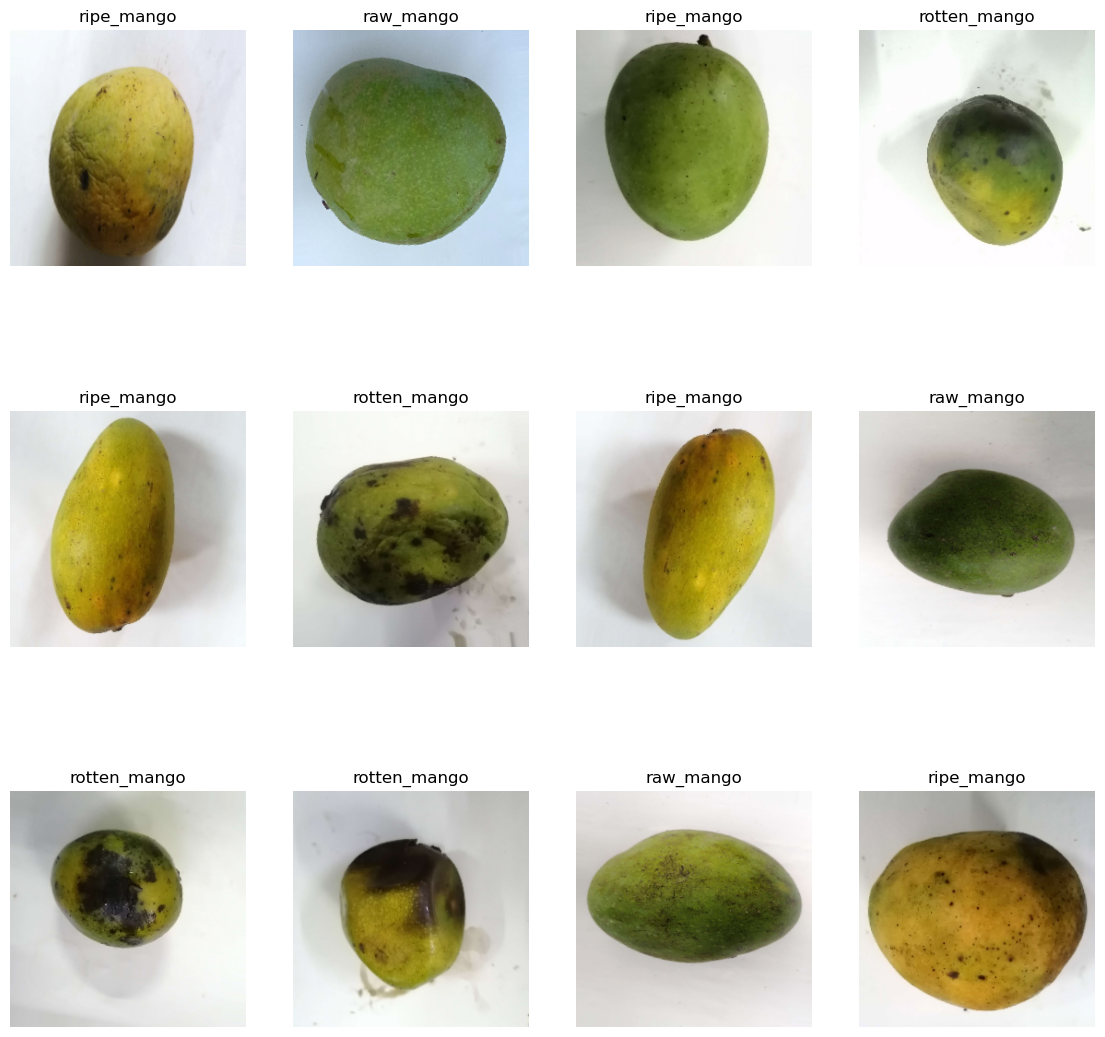

In [7]:
plt.figure(figsize=(14, 14))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
train_size = 0.8
len(dataset)*train_size

28.8

In [9]:
train_ds = dataset.take(28)
len(train_ds)

28

In [10]:
test_ds = dataset.skip(28)
len(test_ds)

8

In [11]:
val_size=0.1
len(dataset)*val_size

3.6

In [12]:
val_ds = test_ds.take(3)
len(val_ds)

3

In [13]:
test_ds = test_ds.skip(3)
len(test_ds)

5

In [14]:
#train data 80%, Test data 10%, Validation 10%
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

28

In [17]:
len(val_ds)

3

In [18]:
len(test_ds)

5

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model 

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

## Data Augmentation

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture: CNN Model 01


Custome CNN with 3 convulation and 3 Pooling layers and dense 256

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 128)        

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
28/28 [==============================] - 57s 2s/step - loss: 2.0951 - accuracy: 0.4498 - val_loss: 0.8471 - val_accuracy: 0.4688
Epoch 2/30
28/28 [==============================] - 53s 2s/step - loss: 0.6778 - accuracy: 0.6998 - val_loss: 0.4609 - val_accuracy: 0.8125
Epoch 3/30
28/28 [==============================] - 54s 2s/step - loss: 0.4560 - accuracy: 0.8136 - val_loss: 0.3165 - val_accuracy: 0.8958
Epoch 4/30
28/28 [==============================] - 55s 2s/step - loss: 0.3454 - accuracy: 0.8717 - val_loss: 0.2109 - val_accuracy: 0.9375
Epoch 5/30
28/28 [==============================] - 51s 2s/step - loss: 0.2724 - accuracy: 0.9018 - val_loss: 0.2576 - val_accuracy: 0.9167
Epoch 6/30
28/28 [==============================] - 52s 2s/step - loss: 0.2898 - accuracy: 0.8951 - val_loss: 0.3434 - val_accuracy: 0.8854
Epoch 7/30
28/28 [==============================] - 53s 2s/step - loss: 0.2439 - accuracy: 0.9118 - val_loss: 0.1505 - val_accuracy: 0.9479
Epoch 8/30
28/28 [==

In [27]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 3s 347ms/step - loss: 0.0406 - accuracy: 0.9750


## Plotting the Accuracy

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

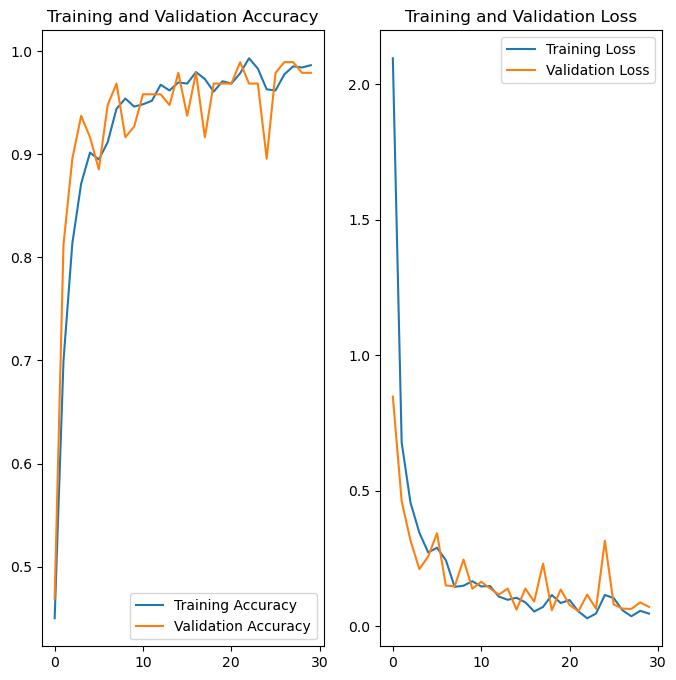

In [29]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Run prediction on a sample image

first image to predict
actual label: ripe_mango
1/1 [==============================] - 1s 521ms/step
predicted label: ripe_mango


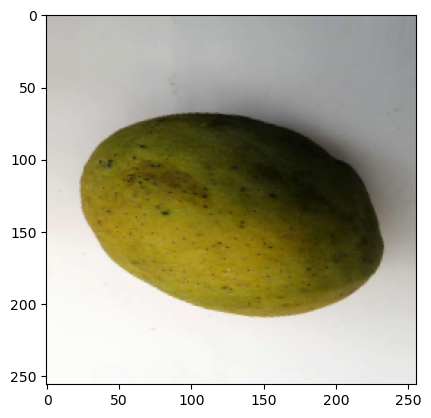

In [30]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

## Inference on few sample images

In [31]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 47ms/step


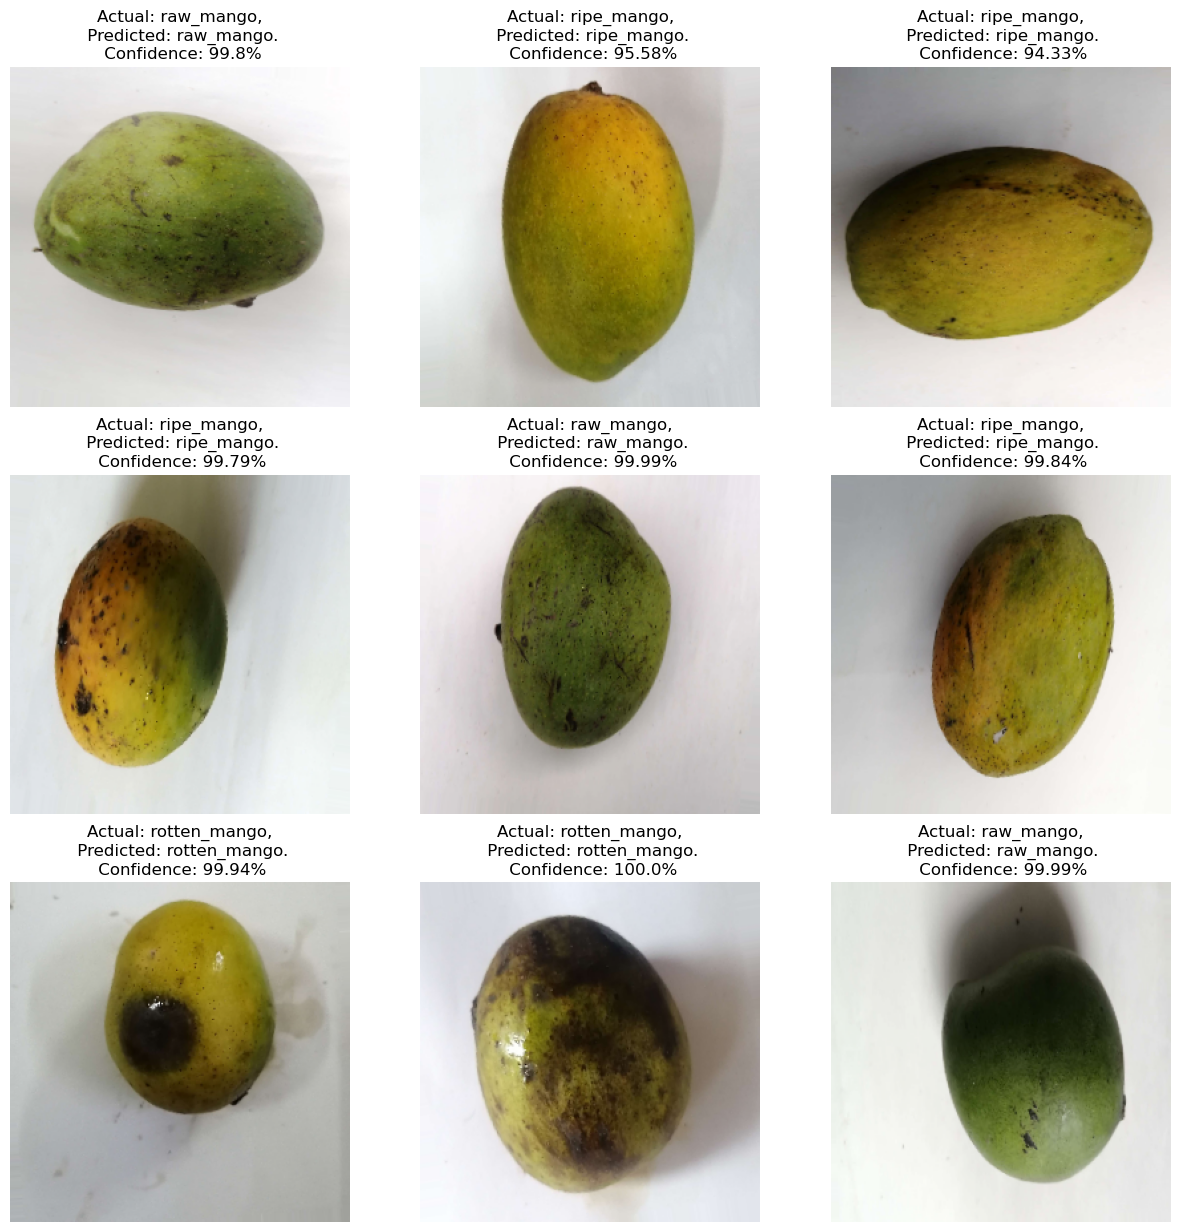

In [32]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Model Architecture: CNN Model 02



Custome CNN with 3 convulation and 3 Pooling layers with dense 128

In [33]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [34]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (32, 60, 60, 128)        

In [35]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [36]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
28/28 [==============================] - 53s 2s/step - loss: 1.4606 - accuracy: 0.4777 - val_loss: 0.8010 - val_accuracy: 0.5104
Epoch 2/30
28/28 [==============================] - 51s 2s/step - loss: 0.7586 - accuracy: 0.6440 - val_loss: 0.5398 - val_accuracy: 0.7917
Epoch 3/30
28/28 [==============================] - 51s 2s/step - loss: 0.5159 - accuracy: 0.7924 - val_loss: 0.4022 - val_accuracy: 0.8333
Epoch 4/30
28/28 [==============================] - 52s 2s/step - loss: 0.4618 - accuracy: 0.8147 - val_loss: 0.3245 - val_accuracy: 0.8542
Epoch 5/30
28/28 [==============================] - 52s 2s/step - loss: 0.5603 - accuracy: 0.7846 - val_loss: 0.6618 - val_accuracy: 0.6667
Epoch 6/30
28/28 [==============================] - 51s 2s/step - loss: 0.5263 - accuracy: 0.7846 - val_loss: 0.3883 - val_accuracy: 0.8542
Epoch 7/30
28/28 [==============================] - 52s 2s/step - loss: 0.3860 - accuracy: 0.8616 - val_loss: 0.2293 - val_accuracy: 0.9167
Epoch 8/30
28/28 [==

In [37]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 2s 396ms/step - loss: 0.0634 - accuracy: 0.9812


# Plotting the Accuracy

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

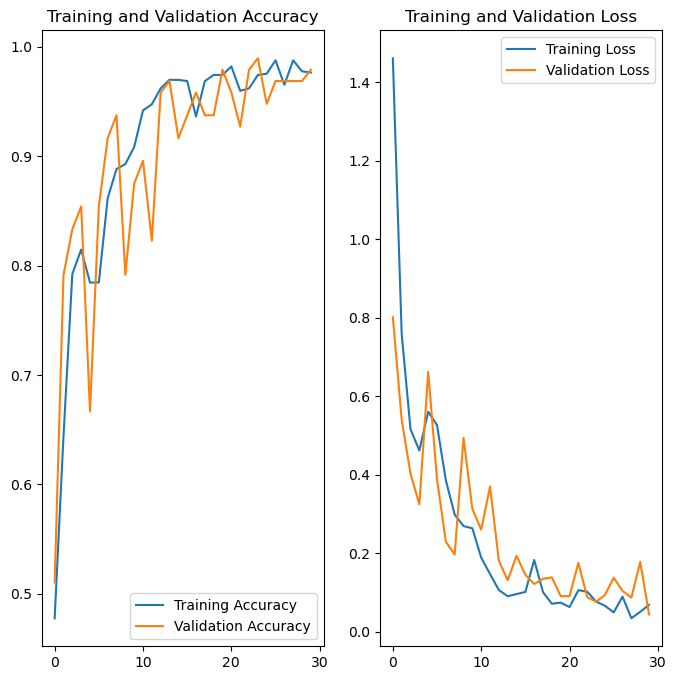

In [39]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Model Architecture: CNN Model 03



# Custome CNN with 6 convulation and 6 Pooling layers with dense 128

In [40]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [41]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 32)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [42]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [43]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
28/28 [==============================] - 28s 978ms/step - loss: 0.9958 - accuracy: 0.5045 - val_loss: 0.8457 - val_accuracy: 0.5938
Epoch 2/30
28/28 [==============================] - 27s 971ms/step - loss: 0.7787 - accuracy: 0.6060 - val_loss: 0.7068 - val_accuracy: 0.7292
Epoch 3/30
28/28 [==============================] - 27s 970ms/step - loss: 0.7744 - accuracy: 0.6127 - val_loss: 0.7050 - val_accuracy: 0.6458
Epoch 4/30
28/28 [==============================] - 27s 968ms/step - loss: 0.6722 - accuracy: 0.6819 - val_loss: 0.5373 - val_accuracy: 0.7292
Epoch 5/30
28/28 [==============================] - 27s 975ms/step - loss: 0.5168 - accuracy: 0.8002 - val_loss: 0.4342 - val_accuracy: 0.8229
Epoch 6/30
28/28 [==============================] - 27s 979ms/step - loss: 0.4529 - accuracy: 0.8382 - val_loss: 0.2839 - val_accuracy: 0.9062
Epoch 7/30
28/28 [==============================] - 27s 973ms/step - loss: 0.3958 - accuracy: 0.8504 - val_loss: 0.4509 - val_accuracy: 0.8333

In [44]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 1s 243ms/step - loss: 0.0874 - accuracy: 0.9688


# Plotting the Accuracy

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

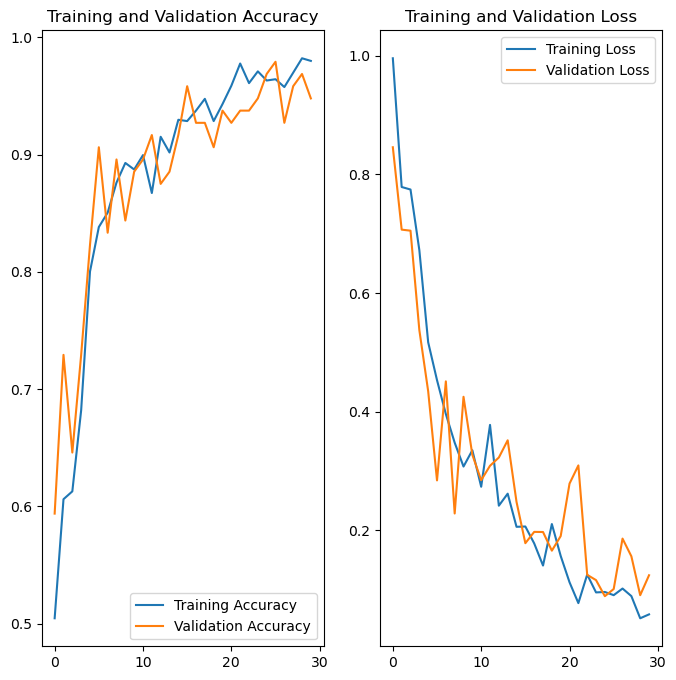

In [46]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Model Architecture: CNN Model 04

# Custome CNN with 4 convulation and 4 Pooling layers with dense 256

In [47]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [48]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 128)        

In [49]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [50]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
28/28 [==============================] - 62s 2s/step - loss: 0.9101 - accuracy: 0.5402 - val_loss: 0.5430 - val_accuracy: 0.7708
Epoch 2/30
28/28 [==============================] - 62s 2s/step - loss: 0.5373 - accuracy: 0.8114 - val_loss: 0.4084 - val_accuracy: 0.8438
Epoch 3/30
28/28 [==============================] - 63s 2s/step - loss: 0.3862 - accuracy: 0.8605 - val_loss: 0.2608 - val_accuracy: 0.8854
Epoch 4/30
28/28 [==============================] - 64s 2s/step - loss: 0.4077 - accuracy: 0.8504 - val_loss: 0.4530 - val_accuracy: 0.8229
Epoch 5/30
28/28 [==============================] - 63s 2s/step - loss: 0.3414 - accuracy: 0.8750 - val_loss: 0.2510 - val_accuracy: 0.9062
Epoch 6/30
28/28 [==============================] - 63s 2s/step - loss: 0.2753 - accuracy: 0.9018 - val_loss: 0.3304 - val_accuracy: 0.8854
Epoch 7/30
28/28 [==============================] - 63s 2s/step - loss: 0.2783 - accuracy: 0.8962 - val_loss: 0.1752 - val_accuracy: 0.9375
Epoch 8/30
28/28 [==

In [51]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 2s 474ms/step - loss: 0.1957 - accuracy: 0.9375


# Plotting the Accuracy

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

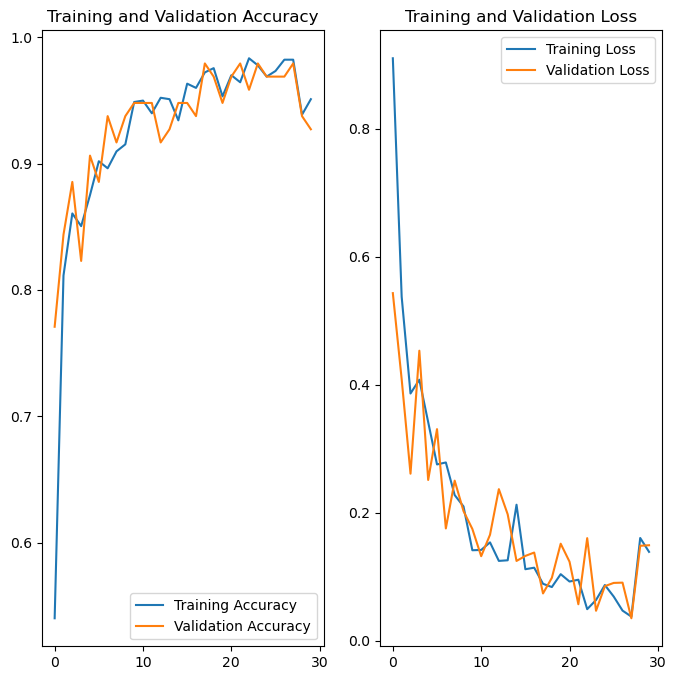

In [53]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# VGG16 Model

In [54]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (256, 256, 3), 
include_top = False,
weights = 'imagenet')

In [55]:
for layer in base_model.layers:
    layer.trainable = False

# Resnet50 Model

In [60]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Flatten
from keras.layers.core import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [61]:
demo_resnet_model = Sequential()

pretrained_model_for_demo= tf.keras.applications.ResNet50(include_top=False,

                   input_shape=(256,256,3),

                   pooling='avg',classes=3,

                   weights='imagenet')

for each_layer in pretrained_model_for_demo.layers:

        each_layer.trainable=False

demo_resnet_model.add(pretrained_model_for_demo)

In [62]:
demo_resnet_model.add(Flatten())

demo_resnet_model.add(Dense(512, activation='relu'))

demo_resnet_model.add(Dense(5, activation='softmax'))

In [63]:
demo_resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [64]:
demo_resnet_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 512)               1049088   
                                                                 
 dense_11 (Dense)            (None, 5)                 2565      
                                                                 
Total params: 24,639,365
Trainable params: 1,051,653
Non-trainable params: 23,587,712
_________________________________________________________________


In [65]:
#Training
history = demo_resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
28/28 [==============================] - 108s 4s/step - loss: 0.5673 - accuracy: 0.7824 - val_loss: 0.1231 - val_accuracy: 0.9479
Epoch 2/30
28/28 [==============================] - 100s 4s/step - loss: 0.1244 - accuracy: 0.9576 - val_loss: 0.0860 - val_accuracy: 0.9688
Epoch 3/30
28/28 [==============================] - 100s 4s/step - loss: 0.0970 - accuracy: 0.9699 - val_loss: 0.0837 - val_accuracy: 0.9896
Epoch 4/30
28/28 [==============================] - 100s 4s/step - loss: 0.0716 - accuracy: 0.9799 - val_loss: 0.0259 - val_accuracy: 1.0000
Epoch 5/30
28/28 [==============================] - 103s 4s/step - loss: 0.0755 - accuracy: 0.9721 - val_loss: 0.0463 - val_accuracy: 0.9896
Epoch 6/30
28/28 [==============================] - 107s 4s/step - loss: 0.0319 - accuracy: 0.9933 - val_loss: 0.0216 - val_accuracy: 1.0000
Epoch 7/30
28/28 [==============================] - 101s 4s/step - loss: 0.0332 - accuracy: 0.9877 - val_loss: 0.0330 - val_accuracy: 0.9896
Epoch 8/30
28

In [66]:
scores = demo_resnet_model.evaluate(test_ds)

5/5 [==============================] - 16s 3s/step - loss: 0.0466 - accuracy: 0.9875
